# Areal interpolation: Tracts to Voting Precincts

This notebook demonstrates the interpolation of an intensive variable (Pct Youth) measured for the census tracts tracts in Riverside and San Bernardino counties in California to the voting precincts in the respective counties.

In [6]:
import tobler
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
import geopandas

In [8]:
tracts = geopandas.read_file("zip://data/tract.zip")

In [9]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,IE_NAME,IE_pct_you,pct Youth,geometry
0,06,071,004201,06071004201,"Census Tract 42.01, San Bernardino County, Cal...",0.214690,0.21,"POLYGON ((-117.34794 34.13602, -117.34725 34.1..."
1,06,071,004202,06071004202,"Census Tract 42.02, San Bernardino County, Cal...",0.204101,0.20,"POLYGON ((-117.32259 34.11639, -117.32259 34.1..."
2,06,071,004401,06071004401,"Census Tract 44.01, San Bernardino County, Cal...",0.237707,0.24,"POLYGON ((-117.35944 34.09045, -117.35944 34.0..."
3,06,065,041912,06065041912,"Census Tract 419.12, Riverside County, California",0.198622,0.20,"POLYGON ((-117.65093 33.87887, -117.65086 33.8..."
4,06,065,043822,06065043822,"Census Tract 438.22, Riverside County, California",0.127917,0.13,"POLYGON ((-117.21237 34.00421, -117.20705 34.0..."


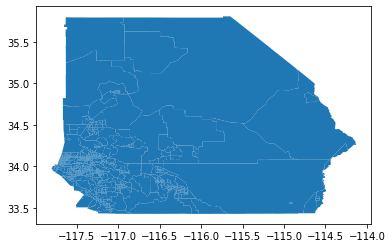

In [10]:
tracts.plot()

In [11]:
sb_precinct = geopandas.read_file("zip://data/sb_precinct.zip")

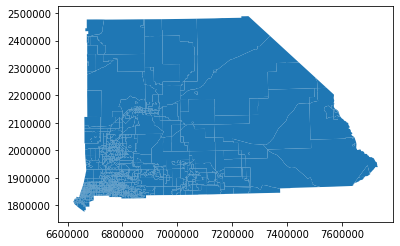

In [12]:
sb_precinct.plot()

In [13]:
riverside_precinct = geopandas.read_file("zip://data/riverside_precinct.zip")

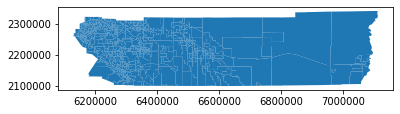

In [14]:
riverside_precinct.plot()

## Check the coordinate reference systems

In [15]:
riverside_precinct.crs

{'proj': 'lcc',
 'lat_0': 32.1666666666667,
 'lon_0': -116.25,
 'lat_1': 32.7833333333333,
 'lat_2': 33.8833333333333,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [16]:
tracts.crs

{'init': 'epsg:4326'}

In [17]:
sb_precinct.crs == tracts.crs

False

In [18]:
sb_precinct.crs

{'proj': 'lcc',
 'lat_0': 33.5,
 'lon_0': -118,
 'lat_1': 34.0333333333333,
 'lat_2': 35.4666666666667,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [19]:
sb_precinct.crs == riverside_precinct.crs

False

## Combine the precincts

In [20]:
#pd.concat([gdf1, gdf2])
import pandas
precincts = pandas.concat([riverside_precinct, sb_precinct], ignore_index=True)

/home/serge/anaconda3/envs/tobler/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
type(precincts)

geopandas.geodataframe.GeoDataFrame

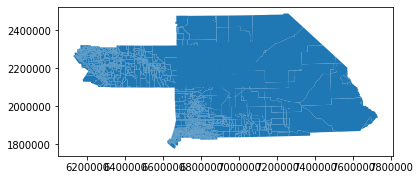

In [22]:
precincts.plot() # different crs' in the two DataFrames

Note the error due to the different crs in the two precinct files.

Set the crs to be the same in each dataframe:

/home/serge/anaconda3/envs/tobler/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


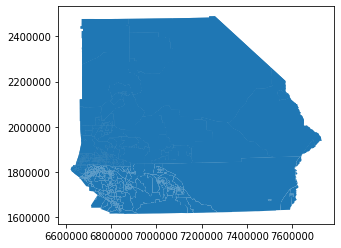

In [23]:
riverside_precinct = tracts.to_crs(sb_precinct.crs)
precincts = pandas.concat([riverside_precinct, sb_precinct], ignore_index=False)
precincts.plot()

In [24]:
precincts.crs

{'proj': 'lcc',
 'lat_0': 33.5,
 'lon_0': -118,
 'lat_1': 34.0333333333333,
 'lat_2': 35.4666666666667,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

## Area interpolation I

In [25]:
area_table = tobler.area_weighted.area_tables(tracts, precincts)

Source and target dataframes have different crs. Please correct.


tobler flags the problem, and warns the user to set the correct crs on the source and target dataframes.

In [26]:
tracts = tracts.to_crs(precincts.crs)

In [27]:
area_table = tobler.area_weighted.area_tables(tracts, precincts) # this will throw an error in geopandas

TopologyException: found non-noded intersection between LINESTRING (7.01348e+06 1.84145e+06, 7.01348e+06 1.84137e+06) and LINESTRING (7.01348e+06 1.84133e+06, 7.01348e+06 1.84145e+06) at 7013480.4226972293 1841454.6831000382


TopologicalError: This operation could not be performed. Reason: unknown

It appears that the concatenate operation in geopandas results in a dataframe with problematic geometries.

We can turn to qgis to do the merge of the two precinct files to get around this.

## Area interpolation II

In [28]:
precincts = geopandas.read_file('data/precincts.shp') # precincts.shp was created in qgis merginging the 2 precinct shapefiles

In [29]:
tracts = tracts.to_crs(precincts.crs)

In [30]:
area_table = tobler.area_weighted.area_tables(tracts, precincts)

In [31]:
estimates = tobler.area_weighted.area_interpolate(tracts, precincts, intensive_variables=['pct Youth'], tables=area_table)

nan values in variable: pct Youth, replacing with 0.0


In [32]:
estimates # we only have intensive variables so the first element will be empty

(array([], dtype=float64), array([[0.42896822],
        [0.23996352],
        [0.70018819],
        ...,
        [0.18013978],
        [0.11000376],
        [0.22      ]]))

In [33]:
pct_youth = estimates[-1]
pct_youth.shape = (-1, 1)
precincts['pct Youth'] = pct_youth

In [34]:
precincts.columns

Index(['fid', 'sVotingPre', 'SUM_lTotal', 'VPMapping', 'PRECINCTID',
       'PRECINCT_N', 'PRCNCT_PRT', 'ABRV_NAME', 'layer', 'path', 'geometry',
       'pct Youth'],
      dtype='object')

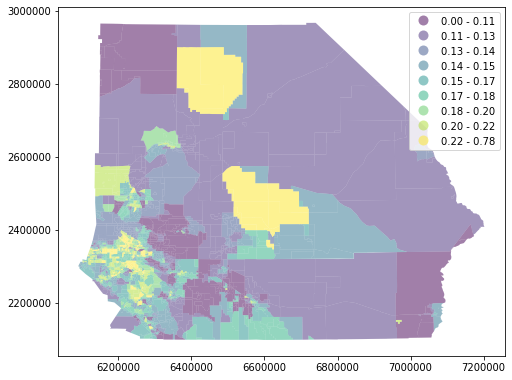

In [35]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = precincts.plot(column='pct Youth', ax=ax, legend=True, alpha=0.5, scheme='Quantiles', k=9)
plt.show()


ValueError: PandasArray must be 1-dimensional.

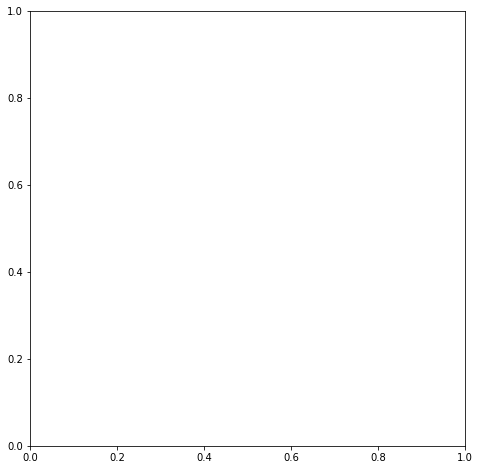

In [36]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tracts.plot(column='pct Youth',ax=ax)
plt.show() # will throw and error since there are NANs in the pct Youth column


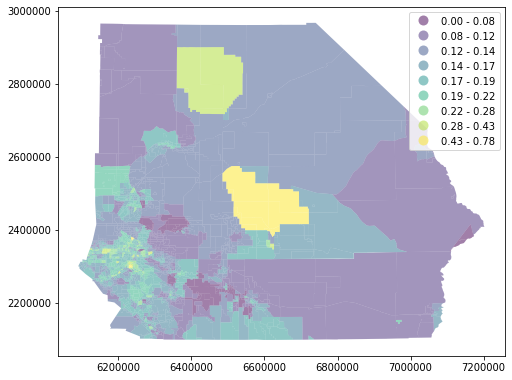

In [37]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = precincts.plot(column='pct Youth', ax=ax, legend=True, alpha=0.5, scheme='fisher_jenks', k=9)
plt.show()


In [38]:
tract_old = tracts[['pct Youth']].values.copy()

In [39]:
import numpy as np
np.where(np.isnan(tract_old))

(array([], dtype=int64), array([], dtype=int64))

In [40]:
tracts.iloc[[91, 497], :]

,STATEFP,COUNTYFP,TRACTCE,GEOID,IE_NAME,IE_pct_you,pct Youth,geometry
91,06,071,980100,06071980100,"Census Tract 9801, San Bernardino County, Cali...",NaN,0.0,"POLYGON ((6253583.061 2344277.513, 6253663.683..."
497,06,065,980004,06065980004,"Census Tract 9800.04, Riverside County, Califo...",NaN,0.0,"POLYGON ((6233691.072 2285767.348, 6233702.832..."


In [41]:
# replace nans in tract data
tract_pct_youth = tracts[['pct Youth']].values
import numpy as np
wherenan = np.isnan(tract_pct_youth)
tract_pct_youth[wherenan] = 0.0
tracts['pct Youth'] = tract_pct_youth

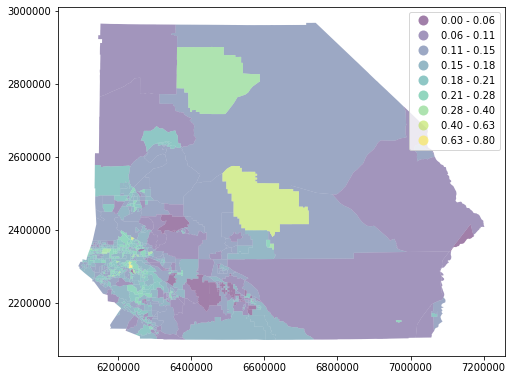

In [42]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tracts.plot(column='pct Youth', ax=ax, legend=True, alpha=0.5, scheme='fisher_jenks', k=9)
plt.show()


In [ ]:
precincts.to_file('data/precincts_interpolated.shp')